### Reconocimiento facial 

- El trabajo consistirá en entrenar una red convolucional con la base de datos de CelebA (contiene imagenes de rostros etiquetadas con 40 características) con algunas de esas características como clasificador hasta obtener un buen modelo, este será guardado.
- Posteriormente, con ese modelo se hará trasfer learning, el objetivo será cambiar el clasificador que identifique sólo si es mi rostro (solo una neurona de salida), entrenar primero con los pesos congelados y finalmente hacer finetuning hasta obtener buenos resultados con la red final.

- Finalmente observaremos la precisión del modelo y sacar una breve conclusion.

In [3]:
import sys
!{sys.executable} -m pip install kagglehub --upgrade

  Using cached kagglehub-0.3.13-py3-none-any.whl.metadata (38 kB)
Using cached kagglehub-0.3.13-py3-none-any.whl (68 kB)


In [155]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Descargamos la base de datos de CelebA  (csv, imagenes)
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

100%|██████████| 1.33G/1.33G [03:23<00:00, 7.01MB/s]

Extracting files...


In [45]:
BASE_DIR = path 
Atrib_file = os.path.join(BASE_DIR, 'list_attr_celeba.csv') # el archivo con las etiquetas y atributos
img_path = os.path.join(BASE_DIR, 'img_align_celeba') #archivo con imagenes
IMAGES_FOLDER = img_path
IMAGES_FOLDER = os.path.join(IMAGES_FOLDER, 'img_align_celeba') #descomprimir de donde se descargó

print(f"Ruta de atributos: {Atrib_file}")
print(f"Ruta de imágenes: {IMAGES_FOLDER}")

Ruta de atributos: C:\Users\Moises\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2\list_attr_celeba.csv
Ruta de imágenes: C:\Users\Moises\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2\img_align_celeba\img_align_celeba


In [69]:
IMG_WIDTH, IMG_HEIGHT = 96, 96 # Dimensiones originales de CelebA
TARGET_SIZE = (128, 128) # Reducimos un poco para agilizar el entrenamiento
BATCH_SIZE = 32

df_attr = pd.read_csv(Atrib_file) #csv de atributos

In [15]:
df_attr.head(10)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
5,000006.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,1,-1,1,-1,-1,1
6,000007.jpg,1,-1,1,1,-1,-1,1,1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
7,000008.jpg,1,1,-1,1,-1,-1,1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
8,000009.jpg,-1,1,1,-1,-1,1,1,-1,-1,...,-1,1,-1,-1,1,-1,1,-1,-1,1
9,000010.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1


Elegiré algunas características como atributos clave para aprender carcaterísticas faciales. Se incluye image_id para identificar donde están los archivos.

In [71]:
target_features = ['image_id', 'Male', 'Smiling', 'Young', 'Black_Hair', 'Oval_Face','Arched_Eyebrows','Bags_Under_Eyes','Eyeglasses', 'Big_Nose','Pointy_Nose', 'Big_Lips','No_Beard','Wavy_Hair']
df_reduced = df_attr[target_features].copy()

In [73]:
for col in target_features[1:]: # convertimos los -1 a 0
    df_reduced[col] = df_reduced[col].apply(lambda x: 0 if x == -1 else 1) 

print(f"Entrenaremos para detectar {len(target_features)-1} características.")

Entrenaremos para detectar 13 características.


In [75]:
# --- CÓDIGO PARA REDUCIR DATOS ---
# Tomamos solo una muestra aleatoria de 20,000 imágenes (aprox 10% del total)
df_reduced = df_reduced.sample(n=20000, random_state=42)


In [77]:
# dividir datos de prueba y de entrenamiento (20 / 80)%
train_df, val_df = train_test_split(df_reduced, test_size=0.2, random_state=42)
print(f"Imágenes para entrenar: {len(train_df)}")
print(f"Imágenes para validar: {len(val_df)}")

Imágenes para entrenar: 16000
Imágenes para validar: 4000


In [79]:
# Usaré aumentación, hace zoom, rota la imagen.. para evitar sobreajuste y que aprenda mejor la red 
train_datagen = ImageDataGenerator(
    rescale=1./255,  #normalizamos
    rotation_range=20,  
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255) 
# para validación solo probamos con la imagen normalizada

In [81]:
# usamos generador de imagenss para no cargar todas directamente, uno para entrenamiento, uno para validacion
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_FOLDER,
    x_col="image_id", #para identificar la imagen
    y_col=target_features[1:], 
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=32,
    class_mode='raw' # 'raw' para multi-label
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGES_FOLDER,
    x_col="image_id",
    y_col=target_features[1:], 
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=32,
    class_mode='raw'
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.


Ahora hay que construir el modelo para entrenar la red.

In [83]:
model = Sequential([
    # Bloque 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Bloque 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Bloque 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    
    # Clasificador
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    # Capa de salida: Tantas neuronas como atributos (13), activación SIGMOID
    Dense(len(target_features)-1, activation='sigmoid') 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\Moises\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [85]:
# Guardar el MEJOR modelo basado en la validación
checkpoint = ModelCheckpoint(
    'celeba_base_model.keras', # Nombre del archivo a guardar
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

# Parar si no mejora después de 5 épocas
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=100,
    validation_data=val_generator,
    validation_steps=50,
    callbacks=[checkpoint, early_stop])

C:\Users\Moises\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 99s 915ms/step - accuracy: 0.4147 - loss: 11271.8125 - val_accuracy: 0.4094 - val_loss: 8812.7451
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.4197 - loss: 64521.5000 - val_accuracy: 0.4019 - val_loss: 39458.8359
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 90s 907ms/step - accuracy: 0.4112 - loss: 159963.1562 - val_accuracy: 0.3956 - val_loss: 94485.0078
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.4278 - loss: 311531.7500 - val_accuracy: 0.3825 - val_loss: 193830.8594
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 90s 897ms/step - accuracy: 0.4100 - loss: 524858.6875 - val_accuracy: 0.3900 - val_loss: 402044.6875
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 939ms/step - accuracy: 0.4259 - loss: 848307.6250 - val_accuracy: 0.4231 - val_loss: 914655.6875


No hemos tenido buen resultado, incluso hay un loss muy grande, lo siguiente que haré será tambien entrenar esta parte con un modelo entrenado, usaré MobileNetB2V2 para esto.

In [88]:
from tensorflow.keras.applications import MobileNetV2

In [183]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [179]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_FOLDER,
    x_col="image_id",
    y_col=target_features[1:], 
    target_size=(224, 224),
    batch_size=32, 
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGES_FOLDER,
    x_col="image_id",
    y_col=target_features[1:], 
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.


In [185]:
base_model.trainable = False # primero con pesos congelados
inputs = Input(shape=(224, 224, 3))

# creamos el modelo 
model = Sequential([
    Input(shape=(224, 224, 3)),
    base_model,
    GlobalAveragePooling2D(), # aplanar características
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(13, activation='sigmoid') # 13 características 
])

In [187]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy', #en realidad es binary porque solo dice si es '0' o '1'
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,629 (9.25 MB)

 Trainable params: 165,645 (647.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [189]:
# Entrenamos 
callbacks = [
    ModelCheckpoint("resnet.keras", save_best_only=True, monitor="val_accuracy"),
    EarlyStopping(monitor="val_accuracy", patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=2, verbose=1)
]

history = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=100,
    validation_data=val_generator,
    validation_steps=50,
    callbacks = callbacks
)

C:\Users\Moises\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.1284 - loss: 0.6062 - val_accuracy: 0.1075 - val_loss: 0.5216 - learning_rate: 1.0000e-04
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.1650 - loss: 0.5457 - val_accuracy: 0.2537 - val_loss: 0.4947 - learning_rate: 1.0000e-04
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.2281 - loss: 0.5209 - val_accuracy: 0.2912 - val_loss: 0.4750 - learning_rate: 1.0000e-04
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.2478 - loss: 0.5141 - val_accuracy: 0.3069 - val_loss: 0.4709 - learning_rate: 1.0000e-04
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.2812 - loss: 0.5025 - val_accuracy: 0.3194 - val_loss: 0.4569 - learning_rate: 1.0000e-04
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.2619 - loss: 0.4932 - val_accuracy: 0.3250 - val_loss: 0.4545 - learning_rate: 1.0000e-04
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - acc

Probemos ahora con ResNet50V2.

In [173]:
from tensorflow.keras.applications import ResNet50V2

In [196]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Escala entre -1 y 1
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_FOLDER,
    x_col="image_id",
    y_col=target_features[1:], 
    target_size=(128, 128), 
    batch_size=32,
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGES_FOLDER,
    x_col="image_id",
    y_col=target_features[1:], 
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw'
)

# Cargamos la base sin la cabeza (include_top=False)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Descongelamos los pesos y entrenamos con las últimas capas
base_model.trainable = True
for layer in base_model.layers[:-30]: # Congelamos todo menos las últimas 30 capas
    layer.trainable = False

# Construimos el modelo
inputs = Input(shape=(128, 128, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x) 
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout fuerte para evitar memorización
outputs = Dense(len(target_features)-1, activation='sigmoid')(x)

model = Model(inputs, outputs)


# Reduce el learning rate si el val_loss no mejora en 2 épocas
# Esto ayuda a salir de estancamientos
lr_reducer = ReduceLROnPlateau(
    monitor='val_binary_accuracy', 
    factor=0.2,   # Divide el LR entre 5
    patience=2, 
    min_lr=1e-6,
    verbose=1
)

early_stopper = EarlyStopping(
    monitor='val_binary_accuracy',
    patience=5,
    restore_best_weights=True
)

model.compile(optimizer=Adam(learning_rate=0.0001), # Empezamos bajito
              loss='binary_crossentropy',
              metrics=['binary_accuracy']) # Usamos binary_accuracy explícito

model.summary()
checkpoint = ModelCheckpoint(
    'mejor_modelo_resnet.keras',
    monitor='val_binary_accuracy', 
    save_best_only=True,
    mode='max', # 'max' porque queremos MAXIMIZAR la precisión
    verbose=1
)
history = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=100,
    validation_data=val_generator,
    validation_steps=50,
    callbacks = [lr_reducer, early_stopper, checkpoint]
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,092,685 (91.91 MB)

 Trainable params: 14,971,405 (57.11 MB)

 Non-trainable params: 9,121,280 (34.79 MB)

C:\Users\Moises\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.6710 - loss: 0.6280
Epoch 1: val_binary_accuracy improved from None to 0.76986, saving model to mejor_modelo_resnet.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 394s 4s/step - binary_accuracy: 0.7213 - loss: 0.5632 - val_binary_accuracy: 0.7699 - val_loss: 0.5034 - learning_rate: 1.0000e-04
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.7665 - loss: 0.4868
Epoch 2: val_binary_accuracy improved from 0.76986 to 0.80120, saving model to mejor_modelo_resnet.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 365s 4s/step - binary_accuracy: 0.7713 - loss: 0.4806 - val_binary_accuracy: 0.8012 - val_loss: 0.4403 - learning_rate: 1.0000e-04
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.7887 - loss: 0.4498
Epoch 3: val_binary_accuracy improved from 0.80120 to 0.80851, saving model to mejor_modelo_resnet.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 377s 4s/step - binary_accuracy: 0.7929 - loss: 0.4429 - val_bin

Podemos observar un mejor entrenamiento, guardaré el modelo y ahora incluiré una carpeta con 25 fotos tomadas de la base de datos y 25 fotos de mi rostro, para usarlo como clasificador.

In [200]:
model.save('celeba_feature_extractor.keras') #guardar el modelo

In [203]:
import os
import shutil
import random

BASE_DIR = 'DatasetF'   # Carpeta donde inclui mis fotos divididas en entrenamiento (20) y validación (5), además de carpetas vacías para agregar imagenes
TRAIN_OTROS = os.path.join(BASE_DIR, 'Train', 'Otros')  
VAL_OTROS = os.path.join(BASE_DIR, 'Val', 'Otros')

SOURCE_IMGS = IMAGES_FOLDER 

print(f"Fuente de imágenes: {SOURCE_IMGS}")
print(f"Destino Train: {TRAIN_OTROS}")
print(f"Destino Val: {VAL_OTROS}")

#  Obtenemos la lista de todas las fotos de CelebA
all_files = os.listdir(SOURCE_IMGS)
random.shuffle(all_files) # Las mezclamos para que sean aleatorias

# Definimos cuántas copiar
# Pondremos 30 fotos de otros en entrenaiento
n_train = 30 
# Pondremos 10 fotos de otros en validación
n_val = 10    


# Copiar para TRAIN
count_t = 0
for i in range(n_train):
    filename = all_files[i]
    src = os.path.join(SOURCE_IMGS, filename)
    dst = os.path.join(TRAIN_OTROS, filename)
    
    # Solo copiamos si es jpg 
    if filename.endswith('.jpg'):
        shutil.copy(src, dst)
        count_t += 1

# Copiar para VAL (usamos los siguientes índices para no repetir)
count_v = 0
for i in range(n_train, n_train + n_val):
    filename = all_files[i]
    src = os.path.join(SOURCE_IMGS, filename)
    dst = os.path.join(VAL_OTROS, filename)
    
    if filename.endswith('.jpg'):
        shutil.copy(src, dst)
        count_v += 1

print(f"¡Listo! Se copiaron {count_t} imágenes a Train/Otros")
print(f"¡Listo! Se copiaron {count_v} imágenes a Val/Otros")

Fuente de imágenes: C:\Users\Moises\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2\img_align_celeba\img_align_celeba
Destino Train: DatasetF\Train\Otros
Destino Val: DatasetF\Val\Otros
¡Listo! Se copiaron 30 imágenes a Train/Otros
¡Listo! Se copiaron 10 imágenes a Val/Otros


In [207]:
from tensorflow.keras.models import load_model
base_learner = load_model('celeba_feature_extractor.keras') #cargamos el modelo 

In [209]:
# Tomamos la salida de la capa anterior a la clasificación
last_output = base_learner.layers[-2].output

In [211]:
# Creamos el nuevo clasificador (0= Otros, 1 = Yo)
new_output = Dense(1, activation='sigmoid', name='output_yo_vs_mundo')(last_output)

In [213]:
# Modelo final
my_face_model = Model(inputs=base_learner.input, outputs=new_output)

In [215]:
# Congelamos todo menos la capa final del clasificador
for layer in my_face_model.layers[:-1]:
    layer.trainable = False


my_face_model.compile(optimizer=Adam(learning_rate=0.0001),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Generadores
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [217]:
train_generator = train_datagen.flow_from_directory(
    'DatasetF/Train',      # La nueva carpeta
    target_size=(128, 128), #Ajustamos a esos pixeles
    batch_size=8,          # Batch pequeño porque hay pocas fotos
    class_mode='binary',   # Binario (Yo vs Otros)
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    'DatasetF/Val',        
    target_size=(128, 128),
    batch_size=8,
    class_mode='binary'
)

Found 50 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


In [219]:
# Entrenamos 
history_final = my_face_model.fit(
    train_generator,
    epochs=10, 
    validation_data=val_generator
)

C:\Users\Moises\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3000 - loss: 1.1435 - val_accuracy: 0.2000 - val_loss: 1.0187
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step - accuracy: 0.3400 - loss: 1.1850 - val_accuracy: 0.2000 - val_loss: 1.0078
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 430ms/step - accuracy: 0.4400 - loss: 1.1857 - val_accuracy: 0.2667 - val_loss: 0.9973
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.3600 - loss: 1.1886 - val_accuracy: 0.2667 - val_loss: 0.9869
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - accuracy: 0.4000 - loss: 0.9833 - val_accuracy: 0.2667 - val_loss: 0.9770
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - accuracy: 0.4000 - loss: 0.9882 - val_accuracy: 0.2667 - val_loss: 0.9675
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 430ms/step - accuracy: 0.4600 - loss: 0.9412 - val_accuracy: 0.2667 - val_loss: 0.9584
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 395ms/step - accuracy: 0.4000 - loss: 0.9554 - val_accuracy: 0.2667 - val_loss: 0

Vamos a hacer fine-tuning, es decir descongelar algunas capas de nuestro modelo anterior para entrenar con el nuevo clasificador. 

In [222]:
base_learner = load_model('celeba_feature_extractor.keras')

# Descongelamos pesos
base_learner.trainable = True 
last_output = base_learner.layers[-2].output 
x = Dropout(0.5)(last_output) # Para evitar memorización
new_output = Dense(1, activation='sigmoid', name='output_final_yo')(x) #nueva capa con 1 neurona

# Modelo final
my_face_model = Model(inputs=base_learner.input, outputs=new_output)

my_face_model.compile(optimizer=Adam(learning_rate=1e-5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

my_face_model.summary()

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,    
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    'DatasetF/Train',
    target_size=(128, 128),
    batch_size=8,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    'DatasetF/Val',
    target_size=(128, 128),
    batch_size=8,
    class_mode='binary',
    shuffle=False # No mezclar validación para ver resultados claros
)

# Imprimir qué clase es cual 
print(f"Diccionario de clases: {train_generator.class_indices}")


history = my_face_model.fit(
    train_generator,
    epochs=15, 
    validation_data=val_generator
)

my_face_model.save('Mi_Reconocimiento_Facial_Final.keras')

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_final_yo (Dense)         │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,089,601 (91.89 MB)

 Trainable params: 14,968,321 (57.10 MB)

 Non-trainable params: 9,121,280 (34.79 MB)

Found 50 images belonging to 2 classes.
Found 15 images belonging to 2 classes.
Diccionario de clases: {'Otros': 0, 'Yo': 1}


C:\Users\Moises\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5200 - loss: 0.7647 - val_accuracy: 0.6000 - val_loss: 0.6446
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 629ms/step - accuracy: 0.5800 - loss: 0.7615 - val_accuracy: 0.6000 - val_loss: 0.5934
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 686ms/step - accuracy: 0.6200 - loss: 0.6620 - val_accuracy: 0.6667 - val_loss: 0.5483
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 680ms/step - accuracy: 0.5800 - loss: 0.7865 - val_accuracy: 0.6667 - val_loss: 0.5091
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 634ms/step - accuracy: 0.7400 - loss: 0.5624 - val_accuracy: 0.8000 - val_loss: 0.4773
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 666ms/step - accuracy: 0.6800 - loss: 0.6544 - val_accuracy: 0.8000 - val_loss: 0.4512
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 839ms/step - accuracy: 0.5800 - loss: 0.6916 - val_accuracy: 0.8667 - val_loss: 0.4289
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 850ms/step - accuracy: 0.6400 - loss: 0.5678 - val_accuracy: 0.8667 - val_loss: 

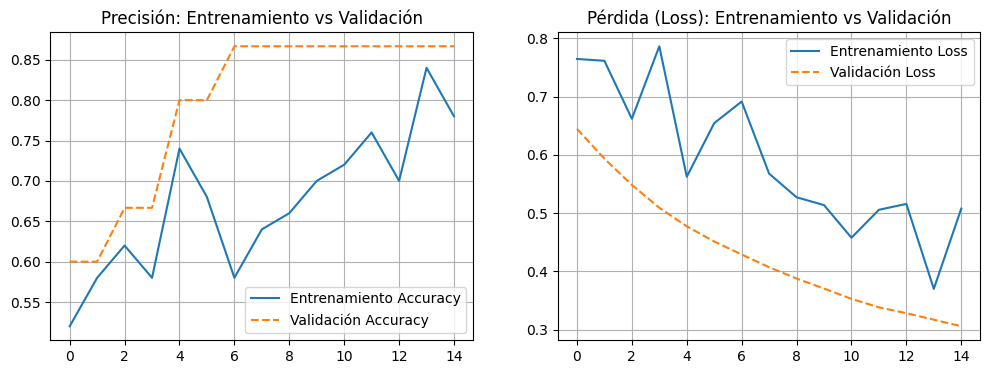

In [224]:
import matplotlib.pyplot as plt

# Extraemos los datos del historial
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Gráfica de Precisión 
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento Accuracy')
plt.plot(epochs_range, val_acc, label='Validación Accuracy', linestyle='--')
plt.legend(loc='lower right')
plt.title('Precisión: Entrenamiento vs Validación')
plt.grid(True)

# Gráfica de la función de costo
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento Loss')
plt.plot(epochs_range, val_loss, label='Validación Loss', linestyle='--')
plt.legend(loc='upper right')
plt.title('Pérdida (Loss): Entrenamiento vs Validación')
plt.grid(True)

plt.show()

Vemos que en validación se obtienen buenos resultados, la precisión indica que el modelo acertaba 13 de las 15 imagenes, las gráficas de entrenamiento pueden mejorar con más datos, además el dropout funciona porque no permite que memorice los datos, en general es un buen resultado contando que tenemos pocas imagenes, también es importante mencionar que me tomé fotos desde diferentes ángulos y con diferente iluminación y ropa, entonces puede expicarse porque hay errores en algunas.

Finalmente, haré una prueba con la foto de un amigo y con una foto mia que la red nunca ha visto, y observaré los resultados.

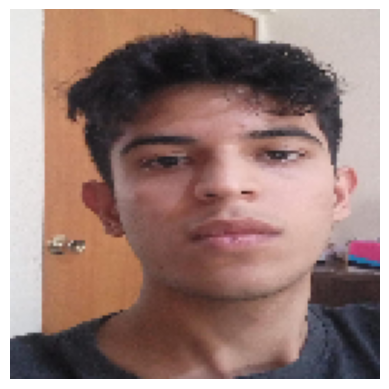

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Probabilidad bruta: 0.5940
✅ RESULTADO: ERES TÚ (59.40% de seguridad)


In [233]:
from tensorflow.keras.preprocessing import image

model = load_model('Mi_Reconocimiento_Facial_Final.keras') 

def probar_foto(nombre_archivo):
    ruta_completa = f"Pruebas/{nombre_archivo}"
    
    try:
        # Cargar imagen y ajustar a 128x128
        img = image.load_img(ruta_completa, target_size=(128, 128))
        
        # Mostrar la imagen
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Preprocesar para la IA
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Crear batch de 1
        img_array = preprocess_input(img_array) # Escalar valores (-1 a 1)

        # Predicción
        prediccion = my_face_model.predict(img_array)
        score = prediccion[0][0]

        print(f"Probabilidad bruta: {score:.4f}")

        # Interpretación 
        if score > 0.5:
            confianza = score * 100
            print(f"✅ RESULTADO: ERES TÚ ({confianza:.2f}% de seguridad)")
        else:
            confianza = (1 - score) * 100
            print(f"❌ RESULTADO: NO ERES TÚ ({confianza:.2f}% de seguridad)")
            
    except FileNotFoundError:
        print(f"Error: No encuentro el archivo '{ruta_completa}'. Revisa el nombre o la carpeta.")

# Probamos con la foto de mi amigo
probar_foto('Yo.jpeg')

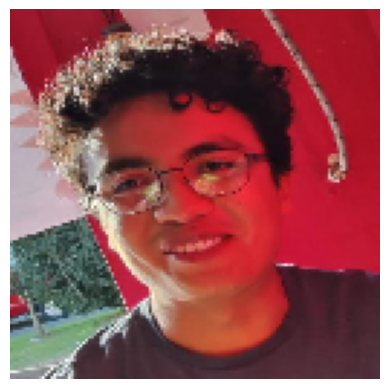

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
Probabilidad bruta: 0.3884
❌ RESULTADO: NO ERES TÚ (61.16% de seguridad)


In [235]:
probar_foto('Amigo.jpeg')